# 线性回归

## 这里会有两个版本，一个是手写版，另一个是Pytorch简单版本

In [32]:
%matplotlib inline
import numpy as np
import seaborn as sns
import torch
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

函数编写清单：
 - 生成数据
 - 读取数据的iterator
 - 定义参数(Param)
 - 定义模型(Model)
 - 定义损失(Loss)
 - 定义优化器(Optim)
 - 训练过程

 ### 手写版

torch.Size([10000, 2]) torch.Size([10000, 1])


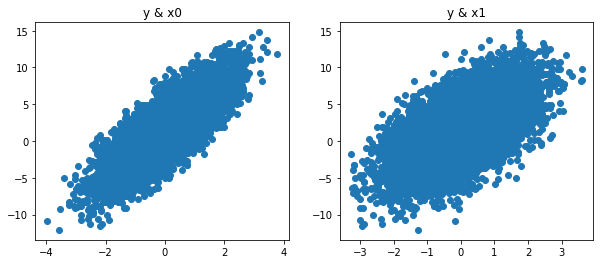

In [124]:
def gen_linear_dataset(W, b, N=10000):
    
    X = torch.randn((N, len(W)))
    y = torch.matmul(X, W) + b
    y += torch.randn(N) * 0.01
    
    return X, y.reshape(-1, 1)

N = 10000
true_W = torch.tensor([3.,  2.2])
true_b = torch.tensor([1.5])
X, y = gen_linear_dataset(true_W, true_b, N)

### Check the function
print(X.shape, y.shape)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for i in [0, 1]:
    axs[i].scatter(X[:, i], y)
    axs[i].set_title(f"y & x{i}")


In [125]:
def data_iter(X, y, batch_num=64):
    
    import random
    
    assert(X.shape[0] == y.shape[0])
    num_sample = X.shape[0]
    ind = list(range(num_sample))
    random.shuffle(ind)
    
    for i in range(0, num_sample, batch_num):
        items = ind[i:min(i+batch_num, num_sample)]
        yield X[items], y[items]
        
data_batches = data_iter(X, y, batch_num=64)

In [132]:
w = torch.normal(0, 1, size=(2, 1), requires_grad=True)
b = torch.normal(0, 1, size=(1, 1), requires_grad=True)

def linear_model(w, b, X):
    return torch.matmul(X, w) + b

def square_loss(y, y_hat):
    return ((y - y_hat) ** 2)

def sgd(params, lr, batch_num):
    
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_num
            param.grad.zero_()    

In [141]:
model = linear_model
loss = square_loss
optimal = sgd

lr = 0.01
epoch_num = 3

for epoch in range(epoch_num):
    
    for batch_X, batch_y in data_iter(X, y, batch_num=64):
        
        batch_y_hat = model(w, b, batch_X)
        batch_loss = loss(batch_y, batch_y_hat).sum()
        batch_loss.backward()
        
        optimal([w, b], lr, batch_num=64)
    
    with torch.no_grad():
        y_hat_all = model(w, b, X)
        loss_all = loss(y, y_hat_all).mean()
        print(f"{epoch}: Loss:{loss_all}")
        
        
print(f"Norm of (w - true_W) is: {torch.norm(w - true_W.reshape(w.shape)).item()} ")
print(f"Norm of (b - true_b) is: {(b - true_b.reshape(b.shape)).item()} ")


0: Loss:9.980626782635227e-05
1: Loss:9.98109026113525e-05
2: Loss:9.981087350752205e-05
Norm of (w - true_W) is: 0.00010538101196289062 
Norm of (b - true_b) is: 6.258487701416016e-05 


### Pytorch版

函数编写清单：
 - 读取数据的iterator
 - 定义参数(Param)
 - 定义模型(Model)
 - 定义损失(Loss)
 - 定义优化器(Optim)
 - 训练过程


In [169]:
## 构建数据reader
data_set = torch.utils.data.TensorDataset(*[X, y])
data_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

## 定义函数
model = torch.nn.Sequential(torch.nn.Linear(w.shape[1], 1))
## 定义参数
model[0].weight.data.normal_(0, 1)
model[0].bias.data.normal_(0, 1)
## 定义loss
loss = torch.nn.MSELoss()
## 定义Optimal
optimal = torch.optim.SGD(model.parameters(), lr=0.02)


In [212]:
epoch_num = 3

for epoch in range(epoch_num):
    
    for batch_X, batch_y in data_loader:
        
        batch_y_hat = model(batch_X)
        batch_loss = loss(batch_y_hat, batch_y)
        # print(batch_y_hat.shape, batch_y.shape, batch_loss)
        
        optimal.zero_grad()
        batch_loss.backward()
        optimal.step()
        
        
    with torch.no_grad():
        y_hat_all = model(X)
        loss_all = loss(y_hat_all, y)
        print(f"Epoch {epoch}: Loss is {loss_all}")
        
        
        
param_dict = dict(model.state_dict())
keys = list(param_dict.keys())
print(f"Norm of (w - true_W) is: {torch.norm(param_dict[keys[0]][0] - true_W)} ")
print(f"Norm of (b - true_b) is: {torch.norm(param_dict[keys[1]][0] - true_b)} ")

Epoch 0: Loss is 0.00010114540782524273
Epoch 1: Loss is 0.00010129979636985809
Epoch 2: Loss is 0.0001013786531984806
Norm of (w - true_W) is: 0.00053319928701967 
Norm of (b - true_b) is: 0.00014698505401611328 
